In [7]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
sns.set_style("whitegrid")

In [8]:
data = pd.read_csv("results/properties_april.csv")

In [9]:
data

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space
0,Office space for sale,"Victoria Island (VI), Lagos","₦52,500,000,000",NaN,NaN,NaN,NaN
1,Office space for sale,"Victoria Island (VI), Lagos","₦30,000,000,000",NaN,NaN,NaN,NaN
2,5 bedroom detached duplex for sale,"Chevron Drive, Lekki, Lagos","₦690,000,000",5.0,5.0,6.0,NaN
3,5 bedroom detached duplex for sale,"Ikate, Lekki, Lagos","₦750,000,000",5.0,5.0,6.0,NaN
4,5 bedroom detached duplex for sale,"Ikate, Lekki, Lagos","₦700,000,000",5.0,5.0,6.0,4.0
...,...,...,...,...,...,...,...
82417,Mixed-use land for sale,"Lateef Jakande, Ikoyi, Lagos","₦1,200,000",NaN,NaN,NaN,NaN
82418,Block of flats for sale,"Gbagada, Lagos","₦70,000,000",NaN,NaN,NaN,NaN
82419,2 bedroom flat / apartment for sale,"Off Freedom Way, Ikate, Lekki, Lagos","₦245,000,000",2.0,2.0,3.0,NaN
82420,2 bedroom flat / apartment for sale,"Ikate, Lekki, Lagos","₦80,000,000",2.0,2.0,2.0,2.0


In [10]:
data.shape

(82422, 7)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82422 entries, 0 to 82421
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_of_house  82422 non-null  object 
 1   location       82422 non-null  object 
 2   price          82422 non-null  object 
 3   bedrooms       60064 non-null  float64
 4   bathrooms      53270 non-null  float64
 5   toilets        54901 non-null  float64
 6   parking_space  35978 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.4+ MB


In [12]:
data.describe()

,bedrooms,bathrooms,toilets,parking_space
count,60064.000000,53270.000000,5.490100e+04,3.597800e+04
mean,4.990743,4.889450,7.837864e+03,9.290820e+02
std,85.682840,25.631511,1.835179e+06,1.380718e+05
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,3.000000,3.000000,4.000000e+00,3.000000e+00
50%,4.000000,4.000000,5.000000e+00,4.000000e+00
75%,5.000000,5.000000,6.000000e+00,5.000000e+00
max,20540.000000,4000.000000,4.300000e+08,2.594840e+07


### Data Cleaning and Normalization

Firstly, it would be more suitable to pull out the `state` and `town` from the location column

In [13]:
data["location"].str.split(",").str[-2].value_counts()

location
 Lekki         27920
 Ajah           5102
 Ikeja          4213
 Ikoyi          3963
Ajah            2828
               ...  
Saki East          1
Aboh Mbaise        1
Keffi              1
 Nassarawa         1
 Rafi              1
Name: count, Length: 478, dtype: int64

In [14]:
data[data["location"].str.contains("lagos")]

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space
636,Filling station for sale,"Hammadiyah B/stop,lagos-abeokuta Express, Ageg...","₦600,000,000",NaN,NaN,NaN,NaN
1155,Commercial property for sale,"Ibadan-lagos Express Way, Ojodu Berger, Ojodu,...","₦750,000,000",NaN,NaN,NaN,NaN
11298,Mixed-use land for sale,"Oloworedo,lagos-ibadan Expressway, Mowe Ofada,...","₦250,000,000",NaN,NaN,NaN,NaN
24903,5 bedroom detached duplex for sale,"Osapa,lekki,lagos, Osapa, Lekki, Lagos","₦300,000,000",5.0,5.0,6.0,3.0
26811,Mixed-use land for sale,"Museyo/aberekodo,ibeju Lekki,lagos.down Town L...","₦47,000,000",NaN,NaN,NaN,NaN
27982,4 bedroom house for sale,"Lekki ,phase 1,lagos ,nigeria, Lekki Phase 1, ...","₦450,000,000",4.0,NaN,NaN,NaN
34010,5 bedroom detached duplex for sale,"Orchid Hotel Road ,lagos Ocean Bay Estate, Lek...","₦380,000,000",5.0,5.0,6.0,3.0
37079,4 bedroom detached duplex for sale,"Ajah ,lagos, Ajah, Lagos","₦120,000,000",4.0,5.0,5.0,3.0
51138,Residential land for sale,"Oju Olobun Street ,victoria Island ,lagos , Ni...","₦1,600,000",NaN,NaN,NaN,NaN
53367,2 bedroom flat / apartment for sale,"Autograph,lagos, Ilasan, Lekki, Lagos","₦120,000,000",2.0,2.0,2.0,NaN


In [15]:
# To remove all white spaces
data["location"] = data["location"].str.strip().replace(r'\s+', ' ', regex=True)
data["location"] = data["location"].str.replace(r'\s*,\s*', ', ', regex=True)

In [16]:
def split_location(location):
    """Splits location into state and town."""
    try:
        parts = location.rsplit(",", 2)  # Split from right, max 2 splits
        state = parts[-1].strip()
        town = parts[-2].strip()
        return state, town
    except IndexError:
        # Handle cases with missing state or town
        return None, None

This line of code takes the `location` column, applies the split_location function to extract the state and town into tuples, unpacks those tuples into separate columns using pd.Series, and then assigns those columns to the "state" and "town" columns of the original DataFrame data.

In [17]:
data[["state", "town"]] = data["location"].apply(split_location).apply(pd.Series)

In [18]:
data['state'] = data['state'].str.title()
data['town'] = data['town'].str.title()

In [19]:
data["state"].unique()

array(['Lagos', 'Oyo', 'Abuja', 'Delta', 'Enugu', 'Ogun', 'Plateau',
       'Osun', 'Nasarawa', 'Ekiti', 'Imo', 'Rivers', 'Akwa Ibom',
       'Anambra', 'Edo', 'Benue', 'Abia', 'Ondo', 'Kaduna', 'Kwara',
       'Cross River', 'Bauchi', 'Niger', 'Bayelsa', 'Kano', 'Ebonyi',
       'Kogi', 'Katsina', 'Sokoto', 'Taraba', 'Jigawa', 'Gombe', 'Yobe',
       'Kebbi', 'Borno'], dtype=object)

In [20]:
data[~data["price"].str.contains("₦")]

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space,state,town
29,4 bedroom flat / apartment for sale,"Banana Island, Ikoyi, Lagos","$1,300,000",4.0,NaN,NaN,NaN,Lagos,Ikoyi
100,Land for sale,"Vi, Victoria Island (VI), Lagos","$1,400,000",NaN,NaN,NaN,NaN,Lagos,Victoria Island (Vi)
106,6 bedroom detached duplex for sale,"Banana Island, Ikoyi, Lagos","$18,000,000",6.0,6.0,7.0,20.0,Lagos,Ikoyi
333,Land for sale,"Off Adeyemo Alakija, Victoria Island (VI), Lagos","$1,400,000",NaN,NaN,NaN,NaN,Lagos,Victoria Island (Vi)
366,3 bedroom flat / apartment for sale,"Off Bourdillon Road, Old Ikoyi, Ikoyi, Lagos","$1,100,000",3.0,3.0,4.0,3.0,Lagos,Ikoyi
...,...,...,...,...,...,...,...,...,...
82301,3 bedroom flat / apartment for sale,"Old Ikoyi, Ikoyi, Lagos","$16,000,000",3.0,NaN,NaN,NaN,Lagos,Ikoyi
82306,5 bedroom detached duplex for sale,"Banana Island, Ikoyi, Lagos","$3,000,000",5.0,5.0,6.0,8.0,Lagos,Ikoyi
82308,7 bedroom detached duplex for sale,"Off Queenâs Drive, Old Ikoyi, Ikoyi, Lagos","$5,000,000",7.0,7.0,8.0,NaN,Lagos,Ikoyi
82367,5 bedroom detached duplex for sale,"Ikoyi, Lagos","$3,000,000",5.0,5.0,6.0,8.0,Lagos,Ikoyi


In [21]:
data.iloc[48141]

type_of_house    2 bedroom flat / apartment for sale
location                 Lekki Phase 1, Lekki, Lagos
price                                   ₦280,000,000
bedrooms                                         2.0
bathrooms                                        2.0
toilets                                          3.0
parking_space                                    NaN
state                                          Lagos
town                                           Lekki
Name: 48141, dtype: object

Converting all dollar denominated pricing to naira

In [22]:
import re

In [23]:
def convert_price(price):
    """
    converts price from string to float.
    And also converts dollar prices to naira.
    """
    if "₦" in price:
        price = price.replace("₦", "").replace(",", "")
        return float(price)
    elif "$" in price:
        price = price.replace("$", "").replace(",", "")
        return float(price) * 1500
    else:
        return None

In [25]:
data["price"] = data["price"].apply(convert_price)

In [27]:
data = data[~data["price"].isna()]

Detecting and removing outliers

In [29]:
data.describe()

,price,bedrooms,bathrooms,toilets,parking_space
count,8.241600e+04,60064.000000,53270.000000,5.490100e+04,3.597800e+04
mean,4.933391e+09,4.990743,4.889450,7.837864e+03,9.290820e+02
std,3.259847e+11,85.682840,25.631511,1.835179e+06,1.380718e+05
min,9.582000e+03,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,9.000000e+07,3.000000,3.000000,4.000000e+00,3.000000e+00
50%,2.000000e+08,4.000000,4.000000,5.000000e+00,4.000000e+00
75%,4.500000e+08,5.000000,5.000000,6.000000e+00,5.000000e+00
max,7.500000e+13,20540.000000,4000.000000,4.300000e+08,2.594840e+07


In [30]:
data = data[data["bedrooms"] < 7]
data = data[data["bathrooms"] < 7]
data = data[data["toilets"] < 10]
data = data[data["parking_space"] < 20]

<Axes: >

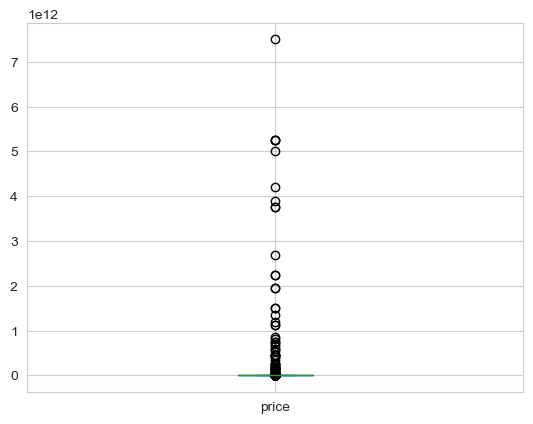

In [31]:
data["price"].plot(kind="box")

<Axes: >

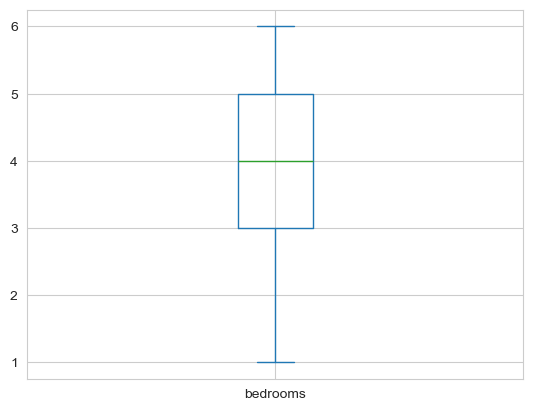

In [32]:
data["bedrooms"].plot(kind="box")

In [33]:
data.describe() 

,price,bedrooms,bathrooms,toilets,parking_space
count,3.046700e+04,30467.000000,30467.000000,30467.000000,30467.000000
mean,2.869069e+09,3.890045,4.038927,4.817343,3.783733
std,9.350017e+10,1.077659,1.139802,1.170780,2.070240
min,1.000000e+05,1.000000,1.000000,1.000000,1.000000
25%,1.200000e+08,3.000000,3.000000,4.000000,2.000000
50%,2.200000e+08,4.000000,4.000000,5.000000,3.000000
75%,4.000000e+08,5.000000,5.000000,6.000000,4.000000
max,7.500000e+12,6.000000,6.000000,9.000000,19.000000


<Axes: >

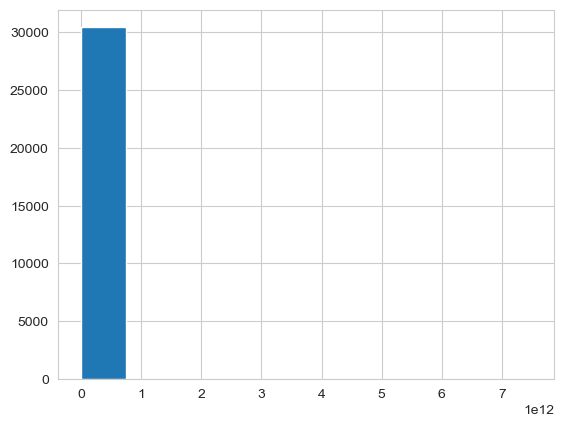

In [35]:
data["price"].hist()

In [36]:
data = data[data["price"] < 4000000000]

<Axes: >

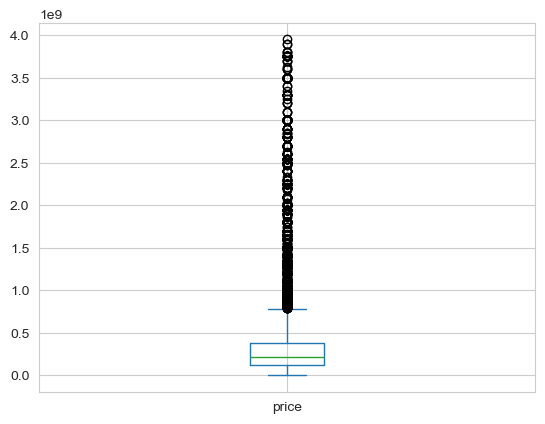

In [37]:
data["price"].plot(kind="box")

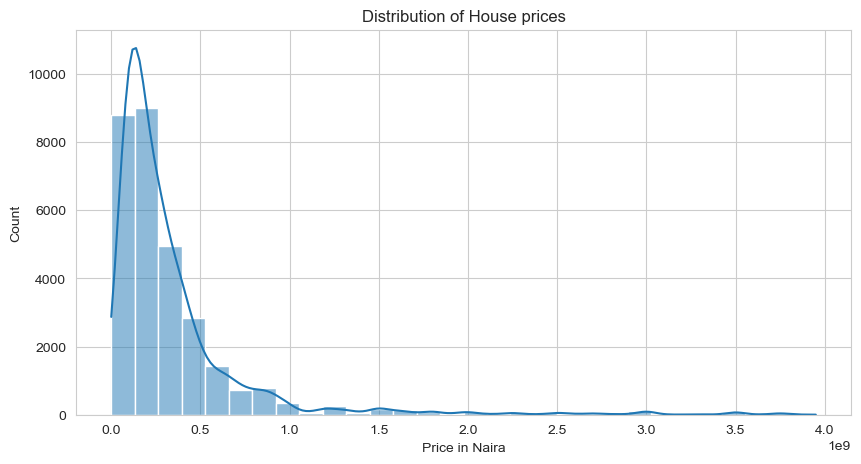

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot(data["price"], bins=30, kde=True)
plt.title("Distribution of House prices")
plt.xlabel("Price in Naira")
plt.show()

In [39]:
data['price_log'] = np.log1p(data['price'])

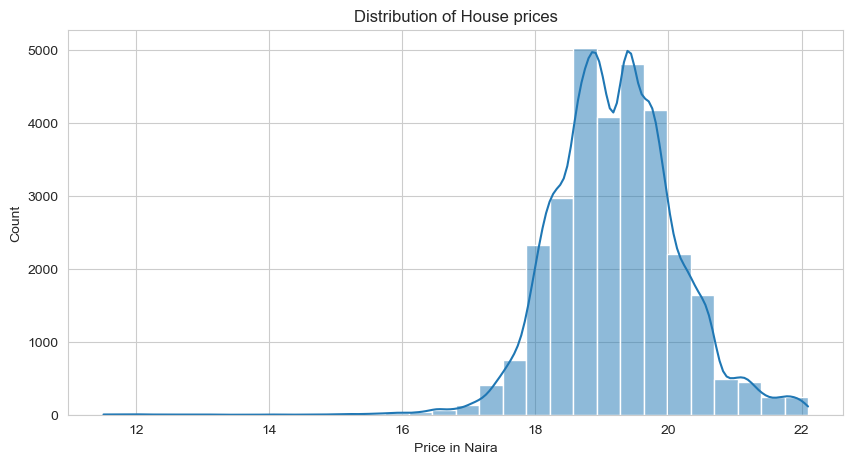

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(data["price_log"], bins=30, kde=True)
plt.title("Distribution of House prices")
plt.xlabel("Price in Naira")
plt.show()

In [41]:
data.describe()


,price,bedrooms,bathrooms,toilets,parking_space,price_log
count,3.012600e+04,30126.000000,30126.000000,30126.000000,30126.000000,30126.000000
mean,3.389271e+08,3.879307,4.028646,4.806114,3.769701,19.207735
std,4.264515e+08,1.075277,1.138337,1.168245,2.063283,0.910876
min,1.000000e+05,1.000000,1.000000,1.000000,1.000000,11.512935
25%,1.200000e+08,3.000000,3.000000,4.000000,2.000000,18.603002
50%,2.200000e+08,4.000000,4.000000,5.000000,3.000000,19.209138
75%,3.850000e+08,5.000000,5.000000,6.000000,4.000000,19.768754
max,3.950000e+09,6.000000,6.000000,9.000000,19.000000,22.096981


In [45]:
data =  data[data["town"] == "Lekki"]
data

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space,state,town,price_log
4,5 bedroom detached duplex for sale,"Ikate, Lekki, Lagos",700000000.0,5.0,5.0,6.0,4.0,Lagos,Lekki,20.366591
6,2 bedroom block of flats for sale,"Ikota, Lekki, Lagos",120000000.0,2.0,2.0,3.0,2.0,Lagos,Lekki,18.603002
9,5 bedroom detached duplex for sale,"Lekki County, Ikota, Lekki, Lagos",230000000.0,5.0,5.0,6.0,9.0,Lagos,Lekki,19.253590
10,4 bedroom terraced duplex for sale,"Ikota, Lekki, Lagos",140000000.0,4.0,4.0,5.0,2.0,Lagos,Lekki,18.757153
11,4 bedroom detached duplex for sale,"Ikota, Lekki, Lagos",200000000.0,4.0,4.0,5.0,3.0,Lagos,Lekki,19.113828
...,...,...,...,...,...,...,...,...,...,...
82406,5 bedroom detached duplex for sale,"Second Toll Gate, Lekki, Lagos",150000000.0,5.0,5.0,5.0,2.0,Lagos,Lekki,18.826146
82408,5 bedroom detached duplex for sale,"Chevron, Lekki, Lagos",190000000.0,5.0,5.0,5.0,2.0,Lagos,Lekki,19.062535
82411,4 bedroom semi-detached duplex for sale,"Close To Osapa London, Lekki, Lagos",100000000.0,4.0,4.0,5.0,2.0,Lagos,Lekki,18.420681
82413,4 bedroom terraced duplex for sale,"Close To Osapa London Estate, Lekki, Lagos",103000000.0,4.0,5.0,5.0,2.0,Lagos,Lekki,18.450240


In [49]:
data["type_of_house"] = data["type_of_house"].str.replace(" for sale", "")
data = data[~data["type_of_house"].str.contains("hotel")]

C:\Users\Kamiye\AppData\Local\Temp\ipykernel_5912\808352019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["type_of_house"] = data["type_of_house"].str.replace(" for sale", "")


In [47]:
data["type_of_house"].unique()

array(['5 bedroom detached duplex', '2 bedroom block of flats',
       '4 bedroom terraced duplex', '4 bedroom detached duplex',
       '6 bedroom detached duplex', '2 bedroom flat / apartment',
       '4 bedroom semi-detached duplex', '4 bedroom house',
       '4 bedroom block of flats', '3 bedroom terraced duplex',
       '1 bedroom detached duplex', '5 bedroom house', '2 bedroom house',
       '3 bedroom flat / apartment', '5 bedroom semi-detached duplex',
       '5 bedroom terraced duplex', '4 bedroom detached bungalow',
       '3 bedroom block of flats', '3 bedroom house',
       '6 bedroom semi-detached duplex', '1 bedroom block of flats',
       '3 bedroom detached duplex', '2 bedroom terraced duplex',
       '1 bedroom flat / apartment', '4 bedroom flat / apartment',
       '3 bedroom detached bungalow', '3 bedroom semi-detached duplex',
       '1 bedroom mini flat (room and parlour)',
       '5 bedroom commercial property', '1 bedroom semi-detached duplex',
       '2 bedroom c

In [43]:
def categorize_house_type(text):
    if 'block of flats' in text:
        return 'Block of Flats'
    elif 'flat / apartment' in text:
        return 'Flat / Apartment'
    elif 'detached duplex' in text:
        return 'Detached Duplex'
    elif 'semi-detached duplex' in text:
        return 'Semi-Detached Duplex'
    elif 'terraced duplex' in text:
        return 'Terraced Duplex'
    elif 'detached bungalow' in text:
        return 'Detached Bungalow'
    elif 'semi-detached bungalow' in text:
        return 'Semi-Detached Bungalow'
    elif 'terraced bungalow' in text:
        return 'Terraced Bungalow'
    elif any(word in text for word in ['restaurant', 'office', 'hostel', 'commercial']):
        return 'Commercial Property'
    else:
        return text

In [44]:
data['house_category'] = data['type_of_house'].apply(categorize_house_type)

In [45]:
data["house_category"].unique()

array(['Detached Duplex', 'Block of Flats', 'Terraced Duplex',
       'Flat / Apartment', '4 bedroom house', '5 bedroom house',
       '2 bedroom house', 'Detached Bungalow', '3 bedroom house',
       '1 bedroom mini flat (room and parlour)', 'Terraced Bungalow',
       'Commercial Property', '6 bedroom house', '7 bedroom house',
       '12 bedroom house', '14 bedroom house', '1 bedroom house',
       '9 bedroom house', '16 bedroom house', '8 bedroom house',
       '10 bedroom house', '11 bedroom house', '18 bedroom house'],
      dtype=object)

## Exploratory Data Analysis

<Axes: xlabel='state'>

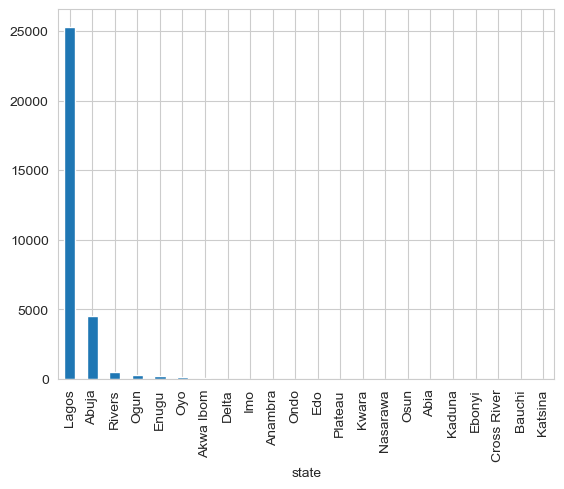

In [46]:
data["state"].value_counts().plot(kind="bar")

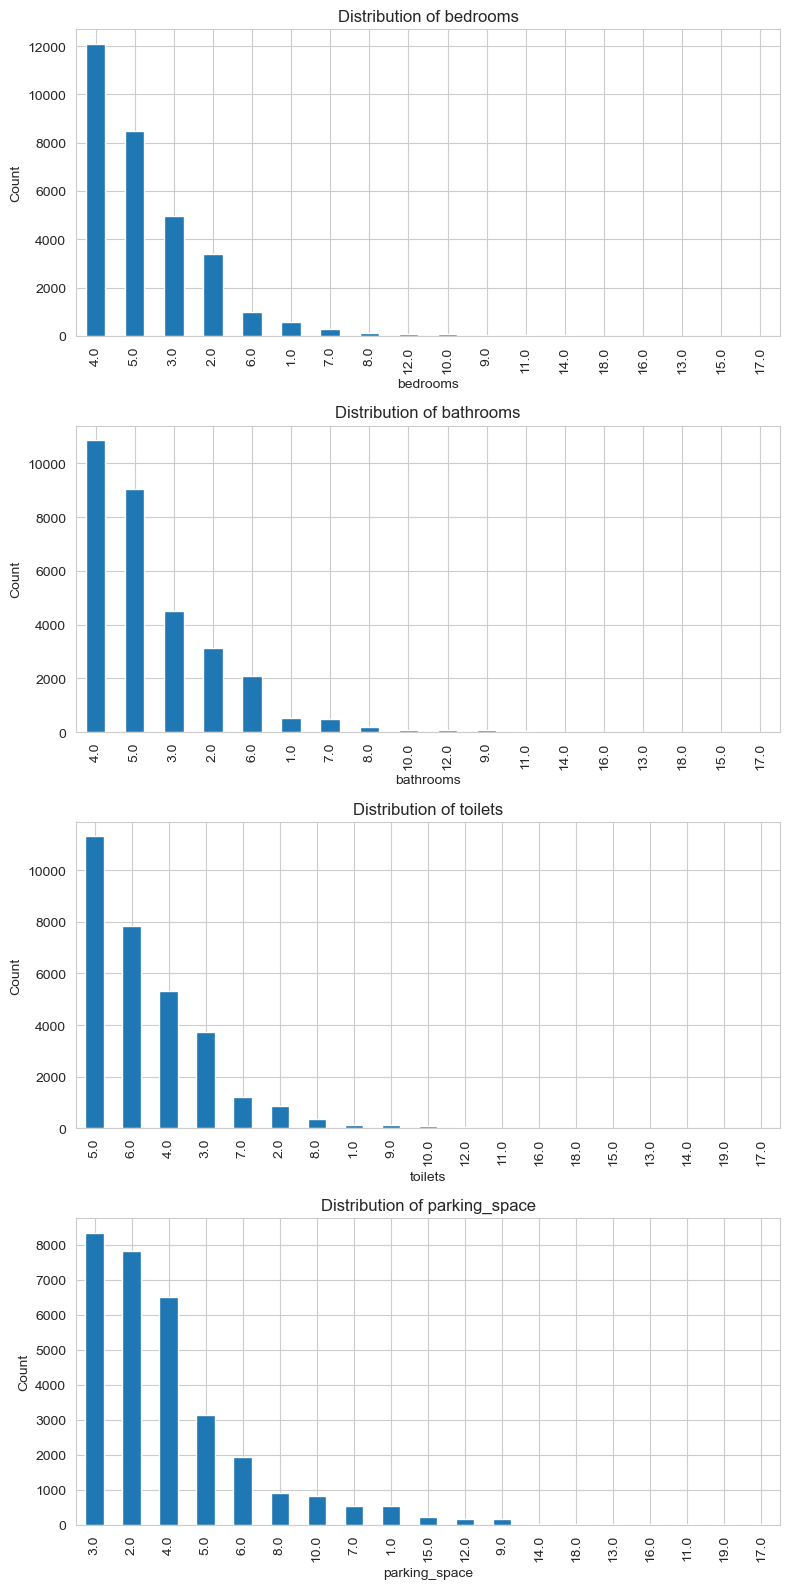

In [47]:
housing_variables = ["bedrooms", "bathrooms", "toilets", "parking_space"]

fig, axes = plt.subplots(len(housing_variables), 1, figsize=(8, 4 * len(housing_variables)))

for i, var in enumerate(housing_variables):
    data[var].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Distribution of {var}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()

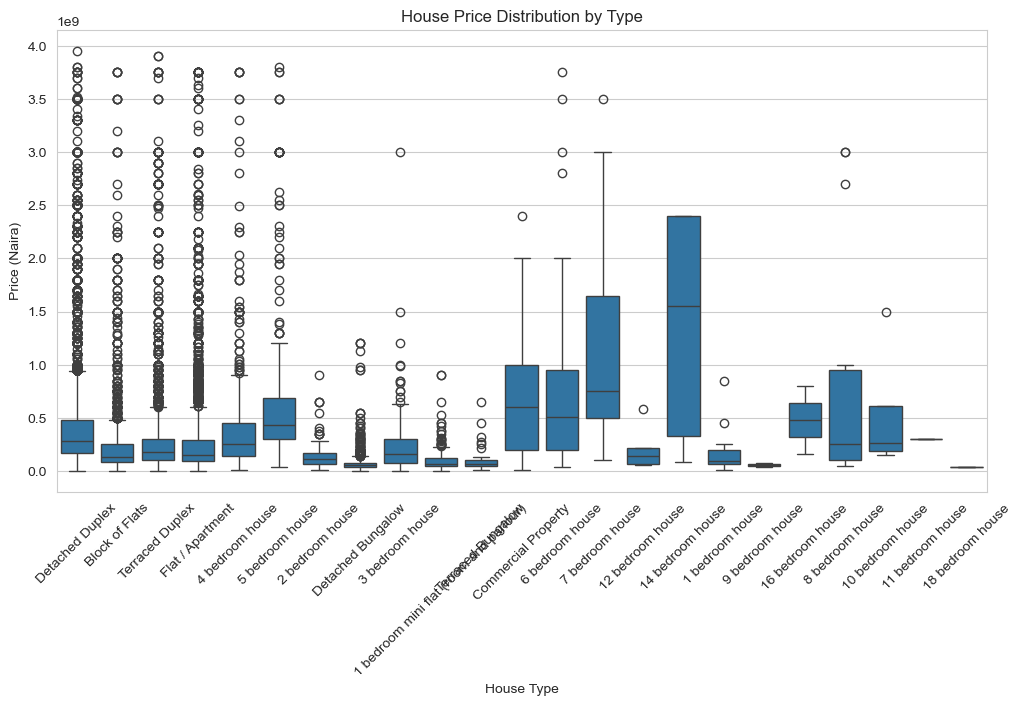

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="house_category", y="price", data=data)
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("House Price Distribution by Type")
plt.xlabel("House Type")
plt.ylabel("Price (Naira)")
plt.show()

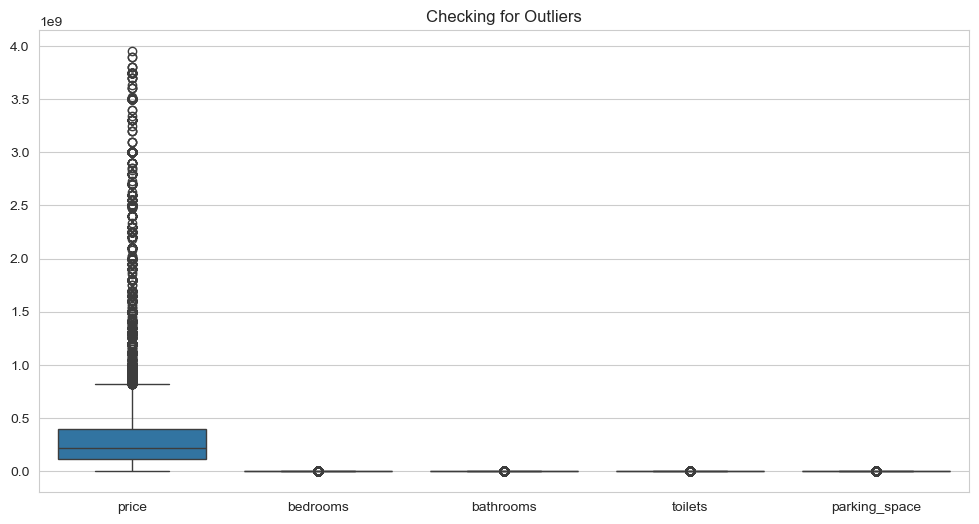

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[["price", "bedrooms", "bathrooms", "toilets", "parking_space"]])
plt.title("Checking for Outliers")
plt.show()

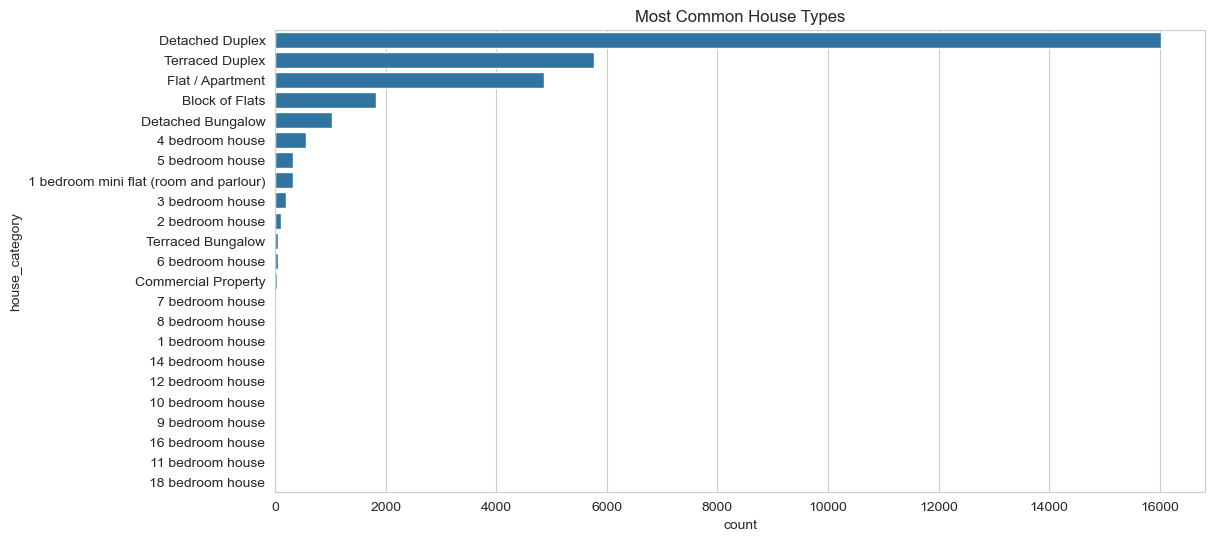

In [50]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data["house_category"], order=data["house_category"].value_counts().index)
plt.title("Most Common House Types")
plt.show()

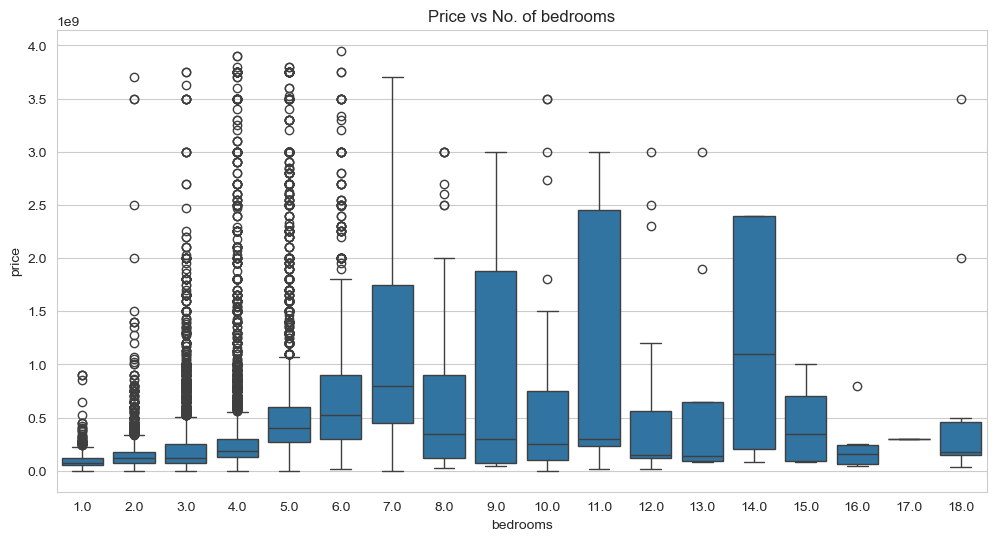

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="bedrooms", y="price", data=data)
plt.title("Price vs No. of bedrooms")
plt.show()

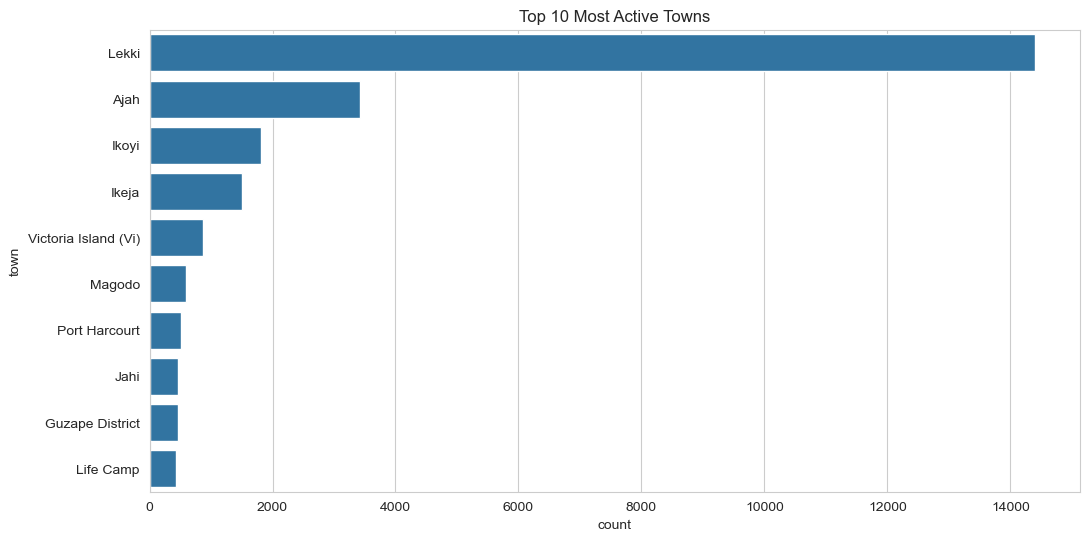

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(y=data["town"], order=data["town"].value_counts().index[:10])  # Top 10 towns
plt.title("Top 10 Most Active Towns")
plt.show()

In [53]:
numerical_data = data[["bedrooms", "bathrooms", "toilets", "parking_space", "price"]]

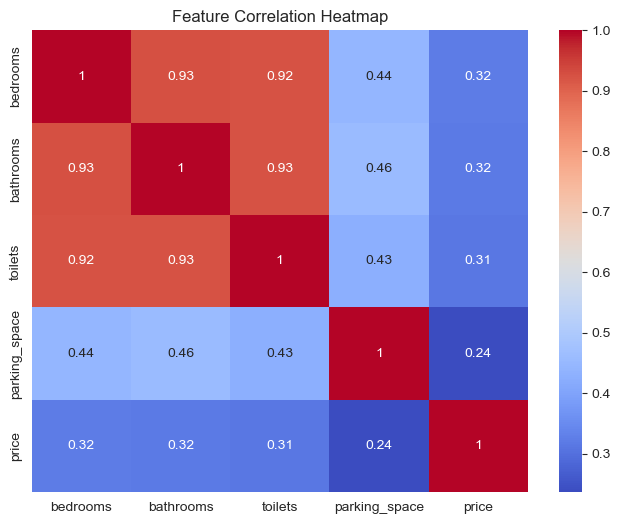

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

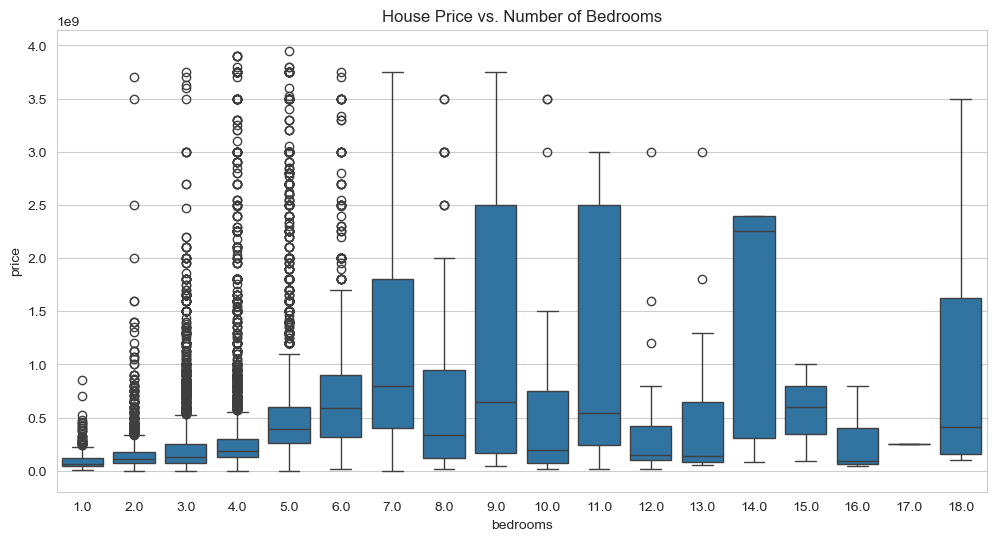

In [1090]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="bedrooms", y="price", data=data)
plt.title("House Price vs. Number of Bedrooms")
plt.show()

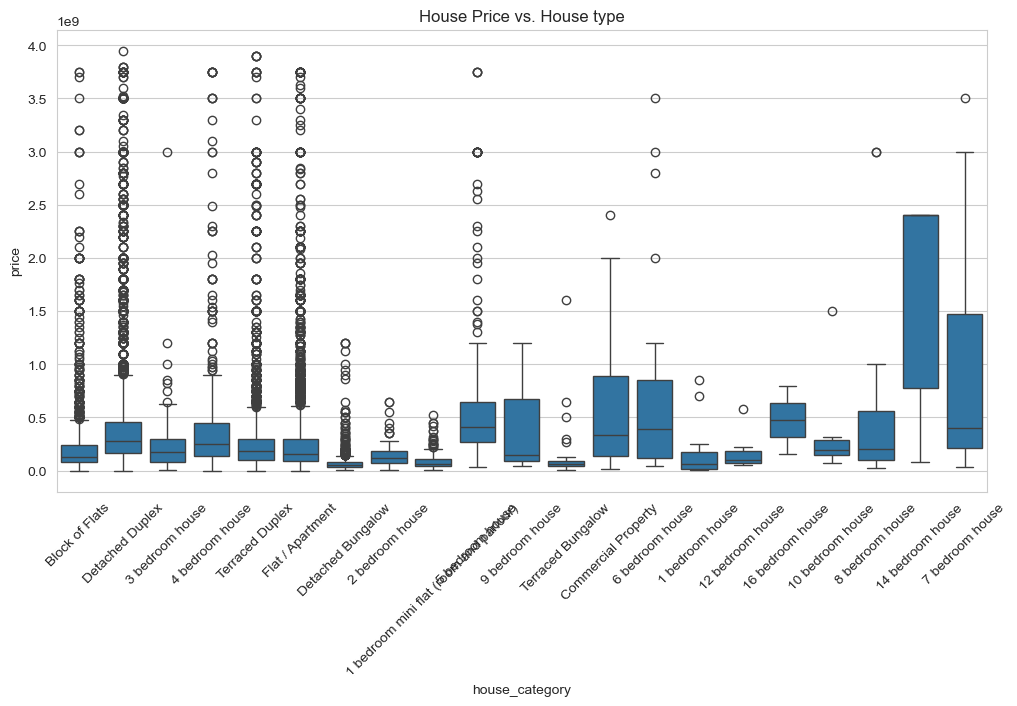

In [1091]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="house_category", y="price", data=data)
plt.title("House Price vs. House type")
plt.xticks(rotation=45)
plt.show()

In [1092]:
# Finding the price per bedroom
data["price_per_bedroom"] = data["price"] / data["bedrooms"]

In [1093]:
data["total_faclities"] = data["bedrooms"] + data["bathrooms"] + data["toilets"] + data["parking_space"]
data["total_faclities"][data["house_category"] == "Semi Detached Duplex"].mean()

nan

In [1094]:
data.drop(columns=["location", "type_of_house"], inplace=True)

In [1095]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# One-hot encode town and state
data_encoded = pd.get_dummies(data, columns=['town', 'state'], drop_first=True)  # Avoid dummy variable trap

# Label encode type_of_house (since it's a single categorical feature)
le = LabelEncoder()
data_encoded['house_category'] = le.fit_transform(data_encoded['house_category'])

# Now redefine X and y
X = data_encoded.drop(columns=['price', 'price_log'])  
y = data_encoded['price_log']

# Train-test split again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [1096]:
model = LinearRegression()
model.fit(X_train, y_train)  # This should now work correctly

LinearRegression()

In [1110]:
# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=200, 
                                     learning_rate=0.1, 
                                     max_depth=5, 
                                     random_state=42)

# Train the model on training data
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [1111]:
y_pred = gb_model.predict(X_test)

In [1112]:
# Calculating Error Metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Score (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.01
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.01
R-Squared Score (R²): 1.00


In [1115]:
# Define new house data
new_house = {
    "bedrooms": 4,
    "bathrooms": 4,
    "toilets": 5,
    "parking_space": 7,
    "house_category": "Detached Bungalow",
    "town": "Ikorodu",
    "state": "Lagos"
}

# Create DataFrame
new_house_data = pd.DataFrame([new_house])

# Add calculated features
new_house_data['price_per_bedroom'] = 0  # Placeholder
new_house_data['total_facilities'] = (
    new_house_data['bedrooms'] + new_house_data['bathrooms'] +
    new_house_data['toilets'] + new_house_data['parking_space']
)

# Encode categorical variables
new_house_data_encoded = pd.get_dummies(new_house_data, columns=["house_category", "town", "state"])

# Create a new DataFrame with required columns
# Instead of adding columns one by one (which causes fragmentation)
# First, create a dictionary with the missing columns
missing_cols_dict = {col: [0] for col in set(X.columns) - set(new_house_data_encoded.columns)}

# Create a DataFrame from the dictionary
missing_cols_df = pd.DataFrame(missing_cols_dict)

# Concatenate horizontally (along columns)
new_house_data_complete = pd.concat([new_house_data_encoded, missing_cols_df], axis=1)

# Select only the columns needed for prediction (in correct order)
new_house_data_final = new_house_data_complete[X.columns]

# Make prediction
predicted_price_log = model.predict(new_house_data_final)
predicted_price = np.expm1(predicted_price_log)[0]  # Extract single value

# Format price output
formatted_price = f"₦{predicted_price:,.2f}"
print("Predicted Price:", formatted_price)

Predicted Price: ₦9,400,433.20


In [1102]:
data["town"].unique()

array(['Lekki', 'Ibeju Lekki', 'Ajah', 'Agege', 'Ikeja',
       'Guzape District', 'Asokoro District', 'Victoria Island (Vi)',
       'Eko Atlantic City', 'Gwarinpa', 'Jahi', 'Idu Industrial', 'Ikoyi',
       'Maryland', 'Gbagada', 'Surulere', 'Wuye', 'Magodo', 'Life Camp',
       'Karmo', 'Galadimawa', 'Ogudu', 'Apo', 'Maitama District',
       'Lugbe District', 'Isheri North', 'Lokogoma District', 'Badagry',
       'Dakibiyu', 'Gaduwa', 'Port Harcourt', 'Alimosho', 'Amuwo Odofin',
       'Mowe Ofada', 'Ado-Odo/Ota', 'Ipaja', 'Isolo', 'Durumi', 'Jabi',
       'Katampe', 'Kado', 'Mabushi', 'Karsana', 'Ojodu', 'Yaba',
       'Ikorodu', 'Kyami', 'Ifako-Ijaiye', 'Epe', 'Agbara-Igbesa', 'Gudu',
       'Arepo', 'Magboro', 'Asaba', 'Garki', 'Karu', 'Ayobo', 'Wuse 2',
       'Uyo', 'Kaura', 'Kubwa', 'Wuse', 'Abeokuta South', 'Enugu',
       'Ibafo', 'Idimu', 'Ikotun', 'Apapa', 'Ilupeju', 'Utako', 'Mushin',
       'Oshodi', 'Sango Ota', 'Karshi', 'Osogbo', 'Ifo', 'Ojo', 'Ibadan',
       'Ketu'